In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics 
import tqdm
import os
import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu
from dredFISH.Analysis import powerplots
import collections

importlib.reload(basicu)

sns.set_context('talk')

In [2]:
fig_dir = '/bigstore/GeneralStorage/fangming/projects/visctx/figures/'
data_dir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/'

# Load data

In [3]:
!ls ../data_dump/candidate_genes*

../data_dump/candidate_genes_vincent_0316.xlsx
../data_dump/candidate_genes_vincent_0328.csv
../data_dump/candidate_genes_vincent_0503.csv
../data_dump/candidate_genes_vincent_0503_v2.csv


In [4]:
f = '../data_dump/candidate_genes_vincent_0503_v2.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Allen marker
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Cdh4,L2/3,A<B>C,CAM,***,NaN
Epha3,L2/3,A<B>C,CAM,***,NaN
Grm8,L2/3,A<B>C,IC,NaN,NaN
...,...,...,...,...,...
Rrad,L2/3,NaN,other,NaN,x
S100a6,L2/3,NaN,other,NaN,x
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [5]:
genes = df0.index.values
allen_genes = df0[~df0['Allen marker'].isnull()].index.values
allen_genes.shape

(14,)

In [6]:
f = os.path.join(data_dir, 'genes_lasso_all83_May13.csv')
g1 = pd.read_csv(f, index_col=0)
print(g1.shape)

f = os.path.join(data_dir, 'genes_lasso_nonallen_May13.csv')
g2 = pd.read_csv(f, index_col=0)
print(g2.shape)

(16, 10)
(17, 10)


In [7]:
# gene lists


In [8]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v3.h5ad')
# zscore
adata.X = basicu.zscore(adata.X, axis=0)
adata

CPU times: user 152 ms, sys: 100 ms, total: 252 ms
Wall time: 252 ms


AnnData object with n_obs × n_vars = 5837 × 83
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Type_colors', 'cluster_colors', "dendrogram_['leiden']", 'hvg', 'layer_colors', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## cluster level profiles

In [9]:
Xk, xclsts = basicu.group_mean(adata.X, adata.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=adata.var.index)
Xk.shape, xclsts.shape, xclsts

((6, 83),
 (6,),
 array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

### classsification based off the ~86 genes (Try LASSO for the minimum set of genes)
- L2/3 vs L4
- L2/3 subtypes
- continuum (UMAP_1 as a proxy)

In [10]:
def get_precision_recall(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    p, r, th = metrics.precision_recall_curve(y_true, y_pred)
    # pidx = np.argsort(p)
    # p = p[pidx]
    # r = r[pidx]
    # p = np.hstack([0, p, 1])
    # r = np.hstack([1, r, 0])
    return p, r

def get_precision_recall_v2(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    pth = np.linspace(0,1,101)
    p = []
    r = []
    for pth1 in pth:
        conf = metrics.confusion_matrix(y_true, y_pred>pth)
        tn, fp, fn, tp = conf.ravel()
        p1 = tp/(tp+fp)
        r1 = tp/(tp+fn)
        p.append(p1)
        r.append(r1)
    
    return p, r

def evaluate(y_true, y_pred, pr_opt='v1'):
    """
    """
    # evaluation
    if pr_opt == 'v1':
        p, r = get_precision_recall(y_true, y_pred)
    elif pr_opt == 'v2':
        p, r = get_precision_recall_v2(y_true, y_pred)
    aupr = metrics.auc(r, p)
    # aupr = -1
    return p, r, aupr

def classifier_pipe(X, y, c=1):
    """
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    ps = []
    rs = []
    auprs = []
    
    y_true = np.empty(len(y))
    y_pred = np.empty(len(y))
    
    
    l0s = []
    l1s = []
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train
        if c > 1e-7:
            model = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=0)
        elif c <= 1e-7:
            model = LogisticRegression(penalty='none', random_state=0)
        # model = LogisticRegression(random_state=0)
        model.fit(X_train, y_train)
        
        # test
        yp = model.predict_proba(X_test)
        
        # results
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()
        l0s.append(l0)
        l1s.append(l1)
        
        # results
        y_true[test_idx] = y_test.values.astype(int)
        y_pred[test_idx] = yp[:,1]
        
        
    return y_true, y_pred, l0s, l1s

def plot_pipe(ax, y_true, y_pred, pr_opt='v1'):
    """
    """
    ps, rs, aupr = evaluate(y_true, y_pred, pr_opt=pr_opt) 
    
    ax.plot(rs, ps, color='C0', linewidth=2)
    ax.text(0,0.1, f"AUPR={aupr:.2f}")
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return ax

In [11]:
def classifier_tuning(X, y, Cs):
    """
    """
    res = []
    ressum = []
    for c in tqdm.tqdm(Cs):
        # run
        y_true, y_pred, l0s, l1s = classifier_pipe(X, y, c=c)
        p, r, aupr = evaluate(y_true, y_pred)
        res.append((y_true, y_pred, l0s, l1s))
        ressum.append({
           'C': c,
           'AUPR': aupr,
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })

    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_ressum(ressum, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['C'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['C'], ressum['AUPR'], '-o')
    ax.set_ylabel('AUPR')
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_multi_ressum(ressum, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['C'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['C'], ressum['AUPR'], '-o')
    ax.set_ylabel('AUPR')
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_res(res, Cs, suptitle=''):
    """
    """
    n = len(Cs)
    nx = 5
    ny = int((n+nx-1)/nx)

    fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
    for i, (oneres, c, ax) in enumerate(zip(res, Cs, axs.flat)):
        y_true, y_pred, _, _ = oneres
        plot_pipe(ax, y_true, y_pred, pr_opt='v1')
        ax.set_title(f'C = {c:.2g}')

    for ax in axs.flat[i+1:]:
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(suptitle, fontsize=20)
    plt.show()

In [12]:
def get_model_used_genes(model, allgenes):
    """
    """
    abscoef = np.abs(model.coef_.reshape(-1,))
    cond = abscoef > 1e-6 
    
    if cond.sum() > 0:
        used_abscoef = abscoef[cond]
        used_genes = allgenes[cond]
        used_coefidx = np.argsort(used_abscoef)[::-1]

        return used_abscoef[used_coefidx], used_genes[used_coefidx]
    else:
        return 0,0

In [13]:
def plot_heatmap(Xplot, Xannot, xlabel='', title='', figsize=(8,5)):
    """
    """
    mosaic = "A"*10+"BCDE"
    fig, axs = plt.subplot_mosaic(mosaic, figsize=figsize)
    ax = axs['A']
    sns.heatmap(Xplot, 
                xticklabels=True,
                yticklabels=True,
                cmap='coolwarm', 
                cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
                ax=ax)
    ax.axvline(3, color='gray', linewidth=1)
    ax.set_yticklabels(ax.get_yticklabels(), 
                       # fontsize=10, 
                       rotation=0)
    ax.set_xlabel(xlabel)

    for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
        nums, catgs = pd.factorize(Xannot.iloc[:,i])
        # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
        sns.heatmap(nums.reshape(-1,1), 
                    annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                    annot_kws={'size': 10},
                    yticklabels=False,
                    # xticklabels=False,
                    fmt='',
                    cbar=False,
                    cmap='jet',
                    ax=ax
                   )
        ax.set_xticklabels([Xannot.columns[i]], rotation=90)
    fig.suptitle(title)
    plt.show()

In [14]:
def plot_multi_ressum(ressum_list, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    for ressum in ressum_list:
        ax.plot(ressum['C'], ressum['coef L0'], '-o')
        ax.set_ylabel('# genes used')
        ax.grid()
        sns.despine(ax=ax)
        ax.set_xscale(scale)
        ax.set_title(title)

    ax = axs[1]
    for ressum in ressum_list:
        ax.plot(ressum['C'], ressum['AUPR'], '-o')
        ax.set_ylabel('AUPR')
        ax.set_xlabel('Regularization')
        ax.set_ylim(ymax=1.02)
        ax.grid()
        sns.despine(ax=ax)
        ax.set_xscale(scale)
        if scale == 'linear':
            ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_multi_ressum_v2(ressum_list, labels, colors, scale='linear', title=''):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    for ressum, label, color in zip(ressum_list, labels, colors):
        ax.plot(ressum['coef L0'], ressum['AUPR'], '-o', markersize=6, 
                label=label,
                color=color,
               )
        
    ax.grid(False)
    ax.set_title(title)
    sns.despine(ax=ax)
    ax.set_xlim([-1, 21])
    # ax.set_ylim([0.5, 1.02])
    ax.set_xlabel('# genes used')
    ax.set_ylabel('AUPR')
    
    ax.legend(bbox_to_anchor=(1,1), loc='upper left') 
    # ax.set_xscale(scale)
    return fig

In [15]:
def identify_used_genes_pipe(adata, col, cluster, model):
    """
    """
    # data
    X = adata.X
    if len(cluster) > 0:
        y = adata.obs[col].str.contains(cluster)
    else:
        y = adata.obs[col].values
        
    allgenes = adata.var.index.values

    model.fit(X, y)
    absweights, ugenes = get_model_used_genes(model, allgenes)
    print(len(ugenes), absweights, ugenes)
    return absweights, ugenes

# comparisons

In [16]:
# data
# L2/3 vs L4
Xall = adata.X
y = adata.obs['cluster'].str.contains('L2/3')

# L2/3 subtypes
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()
Xsub = adatasub.X
y_a = adatasub.obs['cluster'].str.contains('L2/3_A') 
y_b = adatasub.obs['cluster'].str.contains('L2/3_B') 
y_c = adatasub.obs['cluster'].str.contains('L2/3_C') 

print(Xall.shape, Xsub.shape)
print(y.shape, y_a.shape, y_b.shape, y_c.shape)

(5837, 83) (2818, 83)
(5837,) (2818,) (2818,) (2818,)


In [17]:
sns.color_palette("Paired", 2)


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)]

In [18]:
gene_sets = collections.OrderedDict({
    'v0_n10': np.array(
        ['Igfn1', 'Trpc6', 'Baz1a', 'Epha3', 'Cdh13', 
         'Adamts2', 'Chrm2', 'Kcna1', 'Gria3', 'Whrn',]),
    'v1_c83': g1.index.values,
    'v1na_c69': g2.index.values,
})
colors = ['k']+sns.color_palette('Paired', 2)[::-1] #, 'C0', 'C1'] # sns.color_palette('husl', 3)
labels = ['Curated (n=10)', 
          'LASSO (n=16)', 
          'LASSO non-Allen (n=17)',
         ]

In [20]:
res_0 = collections.OrderedDict()
for i, name in enumerate(gene_sets.keys()):
    print(name)
    gidx = basicu.get_index_from_array(genes, gene_sets[name])
    y_true, y_pred, l0s, l1s = classifier_pipe(Xall[:,gidx], y, c=0)
    # results
    res_0[name+'_y_true'] = y_true
    res_0[name+'_y_pred'] = y_pred
    
res_a = collections.OrderedDict()
for i, name in enumerate(gene_sets.keys()):
    print(name)
    gidx = basicu.get_index_from_array(genes, gene_sets[name])
    y_true, y_pred, l0s, l1s = classifier_pipe(Xsub[:,gidx], y_a, c=0)
    # results
    res_a[name+'_y_true'] = y_true
    res_a[name+'_y_pred'] = y_pred
    
res_b = collections.OrderedDict()
for i, name in enumerate(gene_sets.keys()):
    print(name)
    gidx = basicu.get_index_from_array(genes, gene_sets[name])
    y_true, y_pred, l0s, l1s = classifier_pipe(Xsub[:,gidx], y_b, c=0)
    # results
    res_b[name+'_y_true'] = y_true
    res_b[name+'_y_pred'] = y_pred

res_c = collections.OrderedDict()
for i, name in enumerate(gene_sets.keys()):
    print(name)
    gidx = basicu.get_index_from_array(genes, gene_sets[name])
    y_true, y_pred, l0s, l1s = classifier_pipe(Xsub[:,gidx], y_c, c=0)
    # results
    res_c[name+'_y_true'] = y_true
    res_c[name+'_y_pred'] = y_pred

v0_n10
v1_c83
v1na_c69
v0_n10
v1_c83
v1na_c69
v0_n10
v1_c83
v1na_c69
v0_n10
v1_c83
v1na_c69


In [21]:
def plot_pipe_v2(ax, y_true, y_pred, pr_opt='v1', color='C0', label=''):
    """
    """
    ps, rs, aupr = evaluate(y_true, y_pred, pr_opt=pr_opt) 
    
    ax.plot(rs, ps, linewidth=3, color=color, label=f'{label}\nAUPRC={aupr:.2f}')
    # ax.text(0,0.1, f"AUPR={aupr:.2f}")
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return ax

In [22]:
def plot_routine_comparison(ax, title, names, res, colors, labels, legend=True):
    """
    """
    for i, name in enumerate(gene_sets.keys()):
        color = colors[i]
        label = labels[i]
        
        y_true = res[name+'_y_true']
        y_pred = res[name+'_y_pred']
        plot_pipe_v2(ax, y_true, y_pred, color=color, label=label)

    if legend:
        ax.legend(fontsize=14, bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(title)
    return ax

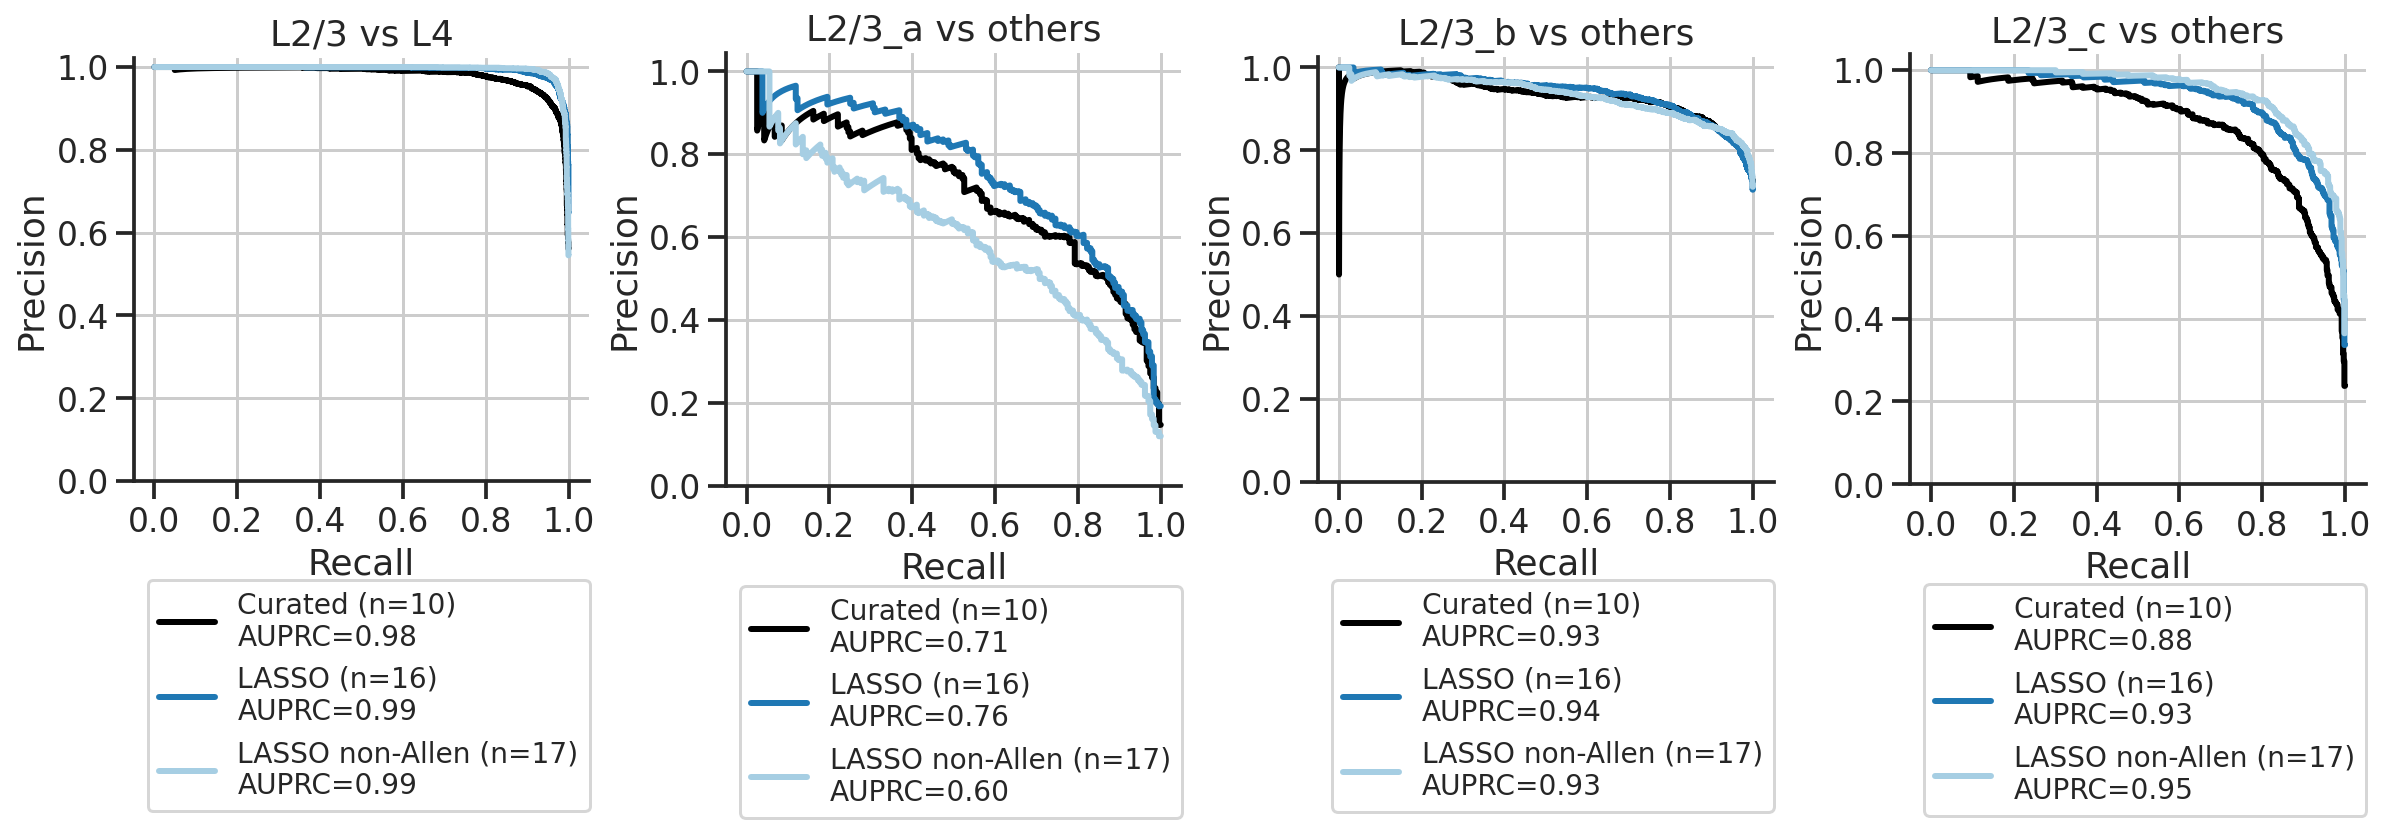

In [23]:
fig, axs = plt.subplots(1,4,figsize=(4*5, 1*5), sharex=True)
ax = axs[0]
plot_routine_comparison(ax, "L2/3 vs L4", list(gene_sets.keys()), res_0, colors, labels)
ax = axs[1]
plot_routine_comparison(ax, "L2/3_a vs others", list(gene_sets.keys()), res_a, colors, labels)
ax = axs[2]
plot_routine_comparison(ax, "L2/3_b vs others", list(gene_sets.keys()), res_b, colors, labels)
ax = axs[3]
plot_routine_comparison(ax, "L2/3_c vs others", list(gene_sets.keys()), res_c, colors, labels)
fig.subplots_adjust(wspace=0.3)
plt.show()

In [24]:
# show heatmaps

In [25]:
gene_sets

OrderedDict([('v0_n10',
              array(['Igfn1', 'Trpc6', 'Baz1a', 'Epha3', 'Cdh13', 'Adamts2', 'Chrm2',
                     'Kcna1', 'Gria3', 'Whrn'], dtype='<U7')),
             ('v1_c83',
              array(['Adamts2', 'Cdh12', 'Cdh13', 'Chrm2', 'Cntn5', 'Cntnap2', 'Gabrg3',
                     'Gria3', 'Grm8', 'Kcnh5', 'Kcnip3', 'Kcnq5', 'Ncam2', 'Nr4a3',
                     'Rorb', 'Sorcs3'], dtype=object)),
             ('v1na_c69',
              array(['Grm8', 'Kcnip3', 'Sorcs3', 'Cntn5', 'Epha6', 'Gabrg3', 'Rfx3',
                     'Egfem1', 'Cntnap2', 'Ncam2', 'Cdh12', 'Epha10', 'Kcnh5', 'Kcnq5',
                     'Rorb', 'Gria3', 'Chrm2'], dtype=object))])

In [26]:
Xannot = Xk.T.copy()
Xannot['v0_n10'] = 0
Xannot.loc[gene_sets['v0_n10'], 'v0_n10'] = 1

Xannot['v1_c83'] = 0
Xannot.loc[gene_sets['v1_c83'], 'v1_c83'] = 1

Xannot['v1na_c69'] = 0 
Xannot.loc[gene_sets['v1na_c69'], 'v1na_c69'] = 1
Xannot

,L2/3_A,L2/3_B,L2/3_C,L4_A,L4_B,L4_C,v0_n10,v1_c83,v1na_c69
Adamts2,2.546986,0.112529,-0.195583,-0.159737,-0.260643,-0.257172,1,1,0
Agmat,-0.136776,0.218520,-0.084725,-0.146723,-0.094824,-0.110209,0,0,0
Astn2,-1.610254,-0.659632,0.254574,-0.069935,0.444226,0.902503,0,0,0
Baz1a,0.335625,0.453374,0.055478,-0.330580,-0.328894,-0.338635,1,0,0
Bdnf,-0.122770,0.183073,-0.217829,-0.345809,0.195868,-0.089660,0,0,0
...,...,...,...,...,...,...,...,...,...
Tbr1,-0.178338,-0.040916,0.292056,-0.197713,0.066646,0.027855,0,0,0
Tenm1,0.798990,-0.247333,-0.476072,1.116446,-0.219821,-0.058894,0,0,0
Trpc6,-0.110657,0.457879,-0.260515,-0.189496,-0.205463,-0.290949,1,0,0
Whrn,-0.749319,-0.698024,-0.594042,0.704984,0.304788,0.837346,1,0,0


In [27]:
Xannot.to_csv(os.path.join(data_dir, 'Lasso_summary_83genes_May13.csv'), header=True, index=True)

In [28]:
geneunion = np.unique(np.hstack([item for key, item in gene_sets.items()]))
geneunion.shape

(26,)

In [29]:
X_s = Xannot.loc[geneunion].copy()
# X_s.index = [gene if gene not in allen_genes else gene+" (Allen)" for gene in X_s.index]
X_s['L4'] = X_s.filter(regex=r'^L4').mean(axis=1)
X_sannot = X_s.filter(regex=r'^v')
X_s = X_s[['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4',
          ]]
X_s

,L2/3_A,L2/3_B,L2/3_C,L4
Adamts2,2.546986,0.112529,-0.195583,-0.225851
Baz1a,0.335625,0.453374,0.055478,-0.332703
Cdh12,-2.467068,-0.474362,0.485395,0.381650
Cdh13,3.061591,-0.040329,-0.248833,-0.132873
Chrm2,-0.857296,-0.713834,0.735769,0.329696
Cntn5,0.301677,-0.533954,-0.929671,0.601188
Cntnap2,-0.660053,-0.291183,1.378190,-0.089826
Egfem1,1.138906,0.037354,0.551781,-0.144039
Epha10,-0.785384,0.093224,0.876070,-0.212086
Epha3,1.070828,0.702349,-0.391102,-0.463805


<AxesSubplot:>

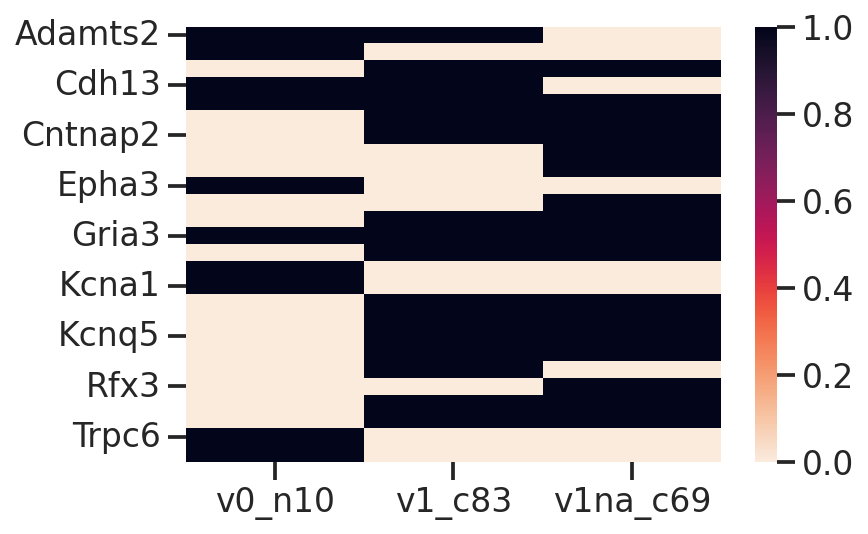

In [30]:
sns.heatmap(X_sannot, cmap='rocket_r')

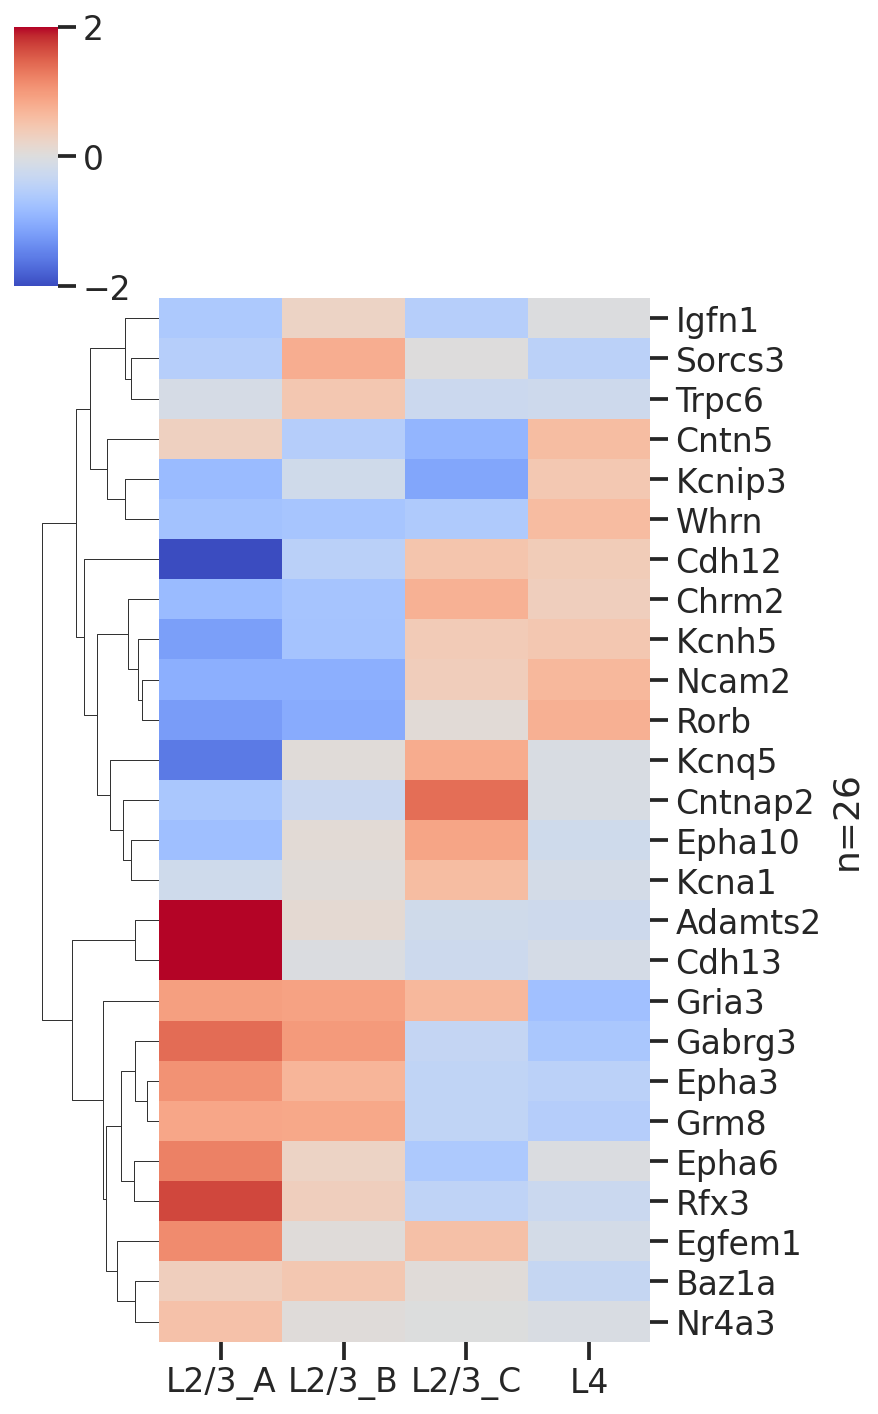

In [31]:
g = sns.clustermap(X_s,
                col_cluster=False,
                   yticklabels=True,
                cmap='coolwarm',
                center=0,
                # vmax=1.5, vmin=-1.5,
                vmax=2, vmin=-2,
                figsize=(6,10), 
               )
g.ax_heatmap.set_ylabel(f'n={len(X_s)}')
plt.show()

In [32]:
# output = os.path.join(data_dir, 'genes_lasso_all83_May13.csv')
# print(output)
# Xannot[cond].to_csv(output, index=True)

In [33]:
# gene_order = [
#     'Cdh13',
#     'Adamts2',
#     'Nr4a3',
#     'Gabrg3',
#     'Gpc6',
    
#     'Sorcs3',
#     # 'Igfn1',
#     # 'Stard8',
#     # 'Epha10',
#     'Kcnq5',
    
#     'Cntnap2',
#     'Cdh12',
#     'Chrm2',
    
#     'Rorb',
#     'Ncam2',
    
#     'Cntn5',
    
#     'Kcnip3',
#     'Gria3',
# ]
# print(len(gene_order))
# print(np.sort(gene_order))

# fig, ax = plt.subplots(figsize=(4,6))
# Xp = X_s.reindex(gene_order).dropna()
# print(Xp.shape)
# sns.heatmap(Xp,
#             cmap='coolwarm',
#             center=0,
#             vmax=1.5, vmin=-1.5,
#             ax=ax,
#             cbar_kws=dict(label='z-scored log-normed expression')
#            )
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_gene_vs_type_heatmap.pdf'))
# plt.show()

In [34]:
gene_order = [
    'Chrm2',
    'Gria3',
    'Adamts2',
    'Cdh13',
    'Baz1a',
    'Epha3',
    'Igfn1',
    'Kcna1',
    'Trpc6',
    'Whrn',    
    'Cdh12',
    'Cntn5',
    'Cntnap2',
    'Gabrg3',
    'Grm8',    
    'Kcnh5',
    'Kcnip3',
    'Kcnq5',
    'Ncam2',
    'Rorb',    
    'Sorcs3',
    'Nr4a3',
    'Egfem1',
    'Epha10',
    'Epha6',
    'Rfx3',
]
len(gene_order)

26

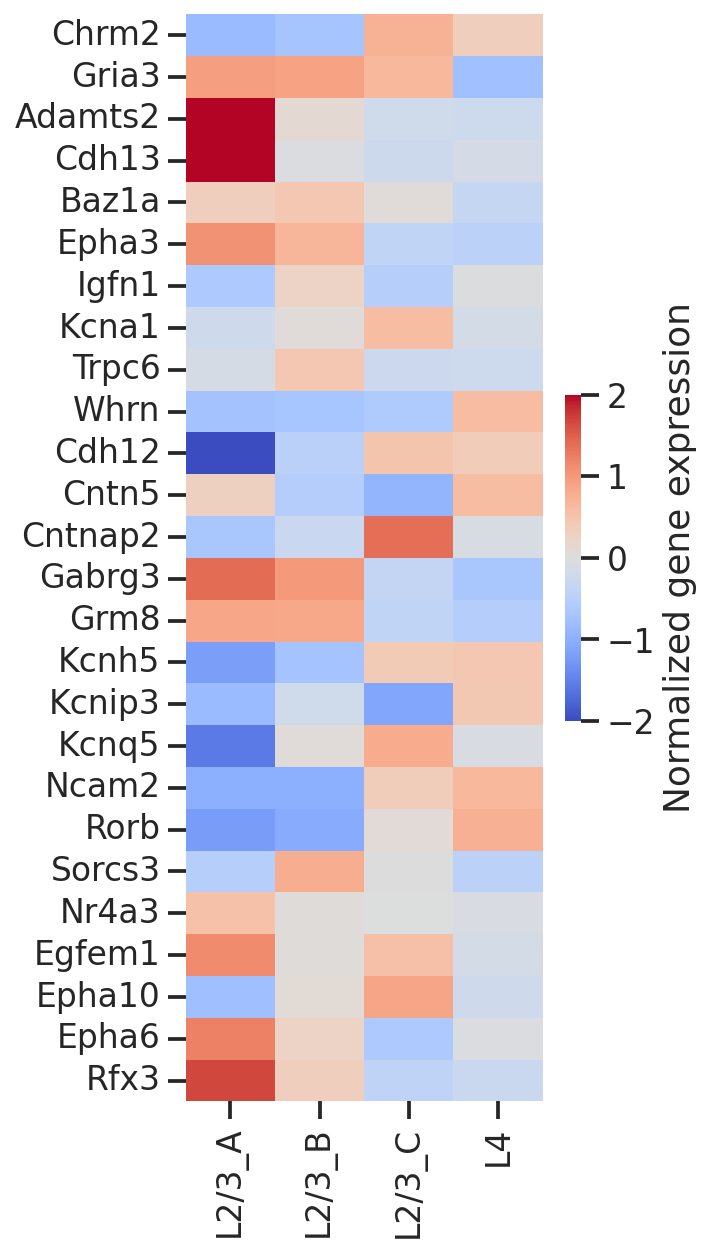

In [35]:
fig, ax = plt.subplots(figsize=(4,10))
Xp = X_s.reindex(gene_order) #.dropna()
sns.heatmap(Xp,
            yticklabels=True,
            cmap='coolwarm',
            center=0,
            vmax=2, vmin=-2,
            ax=ax,
            cbar_kws=dict(shrink=0.3,label='Normalized gene expression')
           )
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_gene_vs_type_heatmap.pdf'))
plt.show()